# Make Water Vapor Profile

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import climlab
import xarray as xr
import scipy.integrate as sp 
import matplotlib.offsetbox as offsetbox
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings
from climlab_rrtmg import rrtmg_lw, rrtmg_sw
from __future__ import division, print_function, absolute_import
import numpy as np
import warnings
from climlab import constants as const
from climlab.radiation.radiation import _Radiation_SW
from climlab.radiation.rrtm.utils import _prepare_general_arguments
from climlab.radiation.rrtm.utils import _climlab_to_rrtm, _climlab_to_rrtm_sfc, _rrtm_to_climlab
import inclass_func


warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

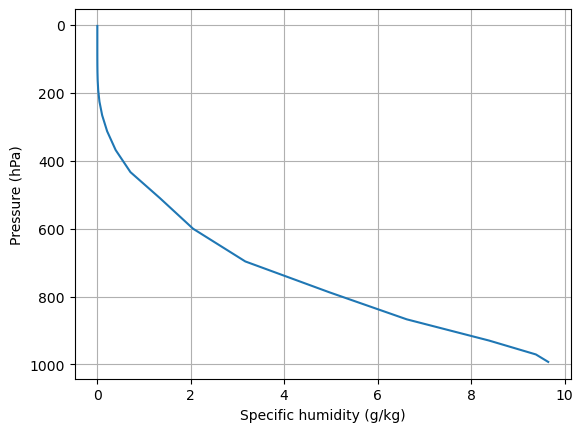

In [43]:
#  Load the model output as we have done before
cesm_data_path = "http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/"
atm_control = xr.open_dataset(cesm_data_path + "cpl_1850_f19/concatenated/cpl_1850_f19.cam.h0.nc")
#  The specific humidity is stored in the variable called Q in this dataset:
atm_control.Q

# Take global, annual average of the specific humidity
weight_factor = atm_control.gw / atm_control.gw.mean(dim='lat')
Qglobal = (atm_control.Q * weight_factor).mean(dim=('lat','lon','time'))
# Take a look at what we just calculated ... it should be one-dimensional (vertical levels)
Qglobal

fig, ax = plt.subplots()
#  Multiply Qglobal by 1000 to put in units of grams water vapor per kg of air
ax.plot(Qglobal*1000., Qglobal.lev)
ax.invert_yaxis()
ax.set_ylabel('Pressure (hPa)')
ax.set_xlabel('Specific humidity (g/kg)')
ax.grid()

# Create Single Model 

In [44]:
#  Make a model on same vertical domain as the GCM
mystate = climlab.column_state(lev=Qglobal.lev, water_depth=2.5)
mystate

AttrDict({'Ts': Field([288.]), 'Tatm': Field([200.  , 203.12, 206.24, 209.36, 212.48, 215.6 , 218.72, 221.84,
       224.96, 228.08, 231.2 , 234.32, 237.44, 240.56, 243.68, 246.8 ,
       249.92, 253.04, 256.16, 259.28, 262.4 , 265.52, 268.64, 271.76,
       274.88, 278.  ])})

In [45]:
radmodel = climlab.radiation.RRTMG(name='Radiation (all gases)',  # give our model a name!
                              state=mystate,   # give our model an initial condition!
                              specific_humidity=Qglobal.values,  # tell the model how much water vapor there is
                              albedo = 0.25,  # this the SURFACE shortwave albedo
                              timestep = climlab.constants.seconds_per_day,  # set the timestep to one day (measured in seconds)
                             )
radmodel

# 1. What does a warming climate look like? 

## A. Clear-sky conditions

Initial condition of climlab by default is set as 288K; Tatm goes from [278,200]

By changing [CO_2]: default: 348ppm; 416.55ppm (present day), 650ppm (tabilizes radiative forcing at 4.5 W m−2 (approximately 650 ppm CO2-equivalent)

In [46]:
# The same model initialized as above
mystate = climlab.column_state(lev=Qglobal.lev, water_depth=2.5)
radmodel = climlab.radiation.RRTMG(name='Radiation (all gases)',  # give our model a name!
                              state=mystate,   # give our model an initial condition!
                              specific_humidity=Qglobal.values,  # tell the model how much water vapor there is
                              albedo = 0.25,  # this the SURFACE shortwave albedo
                              timestep = climlab.constants.seconds_per_day,  # set the timestep to one day (measured in seconds)
                             )

# look at atms profile throughout column at initialization, forward in time 1 timestep and at equilibrium (2 panels) * default level
# At initialization, LW_flux_up would be all 0. 
radmodel_t0 =climlab.to_xarray(radmodel.LW_flux_up)
print(radmodel_t0)

<xarray.DataArray (lev_bounds: 27)>
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Coordinates:
  * lev_bounds  (lev_bounds) float64 0.0 5.467 10.68 18.96 ... 950.1 981.6 1e+03


We'll check out what the longwave profile looks like throughout the atmosphere. 

In [47]:
# To equilibrium - keep running model with the net imbalance at TOA is smaller than .01 Wm-2 
count = 0 

radmodel.step_forward()

while np.abs(radmodel.ASR - radmodel.OLR) > 0.01:
    # Take one step forward in time 
    if count == 0:
        radmodel_lw_t1 = climlab.to_xarray(radmodel.LW_flux_net)
        radmodel_sw_t1 = climlab.to_xarray(radmodel.SW_flux_net)
    radmodel.step_forward()
    count+=1 
radmodel_sw_eqm = climlab.to_xarray(radmodel.SW_flux_net)
radmodel_lw_eqm = climlab.to_xarray(radmodel.LW_flux_net)

count

423

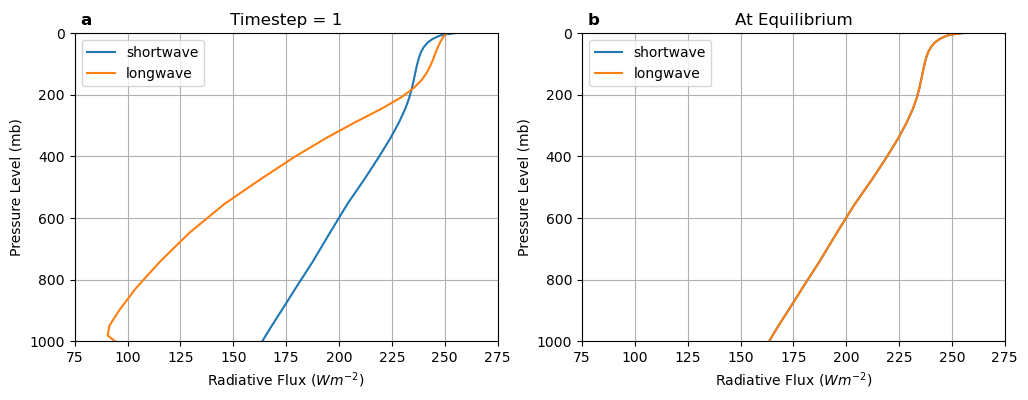

In [48]:
# Vertical Profile of net SW and LW Fluxes in the atmosphere at different timesteps -> demonstrates atmospheric adjustments over time in the model 
p_lev = radmodel_sw_eqm.lev_bounds

#figcheck 
fig = plt.figure(figsize=(12,4))
ax1 = plt.subplot2grid((1,2), (0,0))
ax2 = plt.subplot2grid((1,2), (0,1))
plt.setp([ax1,ax2], xlim=(75,275), ylim=(0,1000))

ax1.plot(radmodel_sw_t1,p_lev,label='shortwave')
ax1.plot(radmodel_lw_t1,p_lev,label='longwave')
ax1.invert_yaxis()
ax1.set_xlabel('Radiative Flux ($Wm^{-2}$)')
ax1.set_ylabel('Pressure Level (mb)')
ax1.set_title('Timestep = 1')
ax1.legend()
ax1.grid()

ax2.plot(radmodel_sw_eqm,p_lev,label='shortwave')
ax2.plot(radmodel_lw_eqm,p_lev,label='longwave')
ax2.set_xlabel('Radiative Flux ($Wm^{-2}$)')
ax2.set_ylabel('Pressure Level (mb)')
ax2.set_title('At Equilibrium')
ax2.invert_yaxis()
ax2.legend()
ax2.grid()
make_textbox(ax1,'a')
make_textbox(ax2,'b')

In [49]:
olr_348 = [] #TOA outgoing longwave radiation in W/m2 (+ve up)
asr_348 = [] #TOA absorbed shortwave radiation at TOA in W/m2 (+ve down)
net_348 = [] #net TOA radiation 
olr_416 = [] #TOA outgoing longwave radiation in W/m2 (+ve up)
asr_416 = [] #TOA absorbed shortwave radiation at TOA in W/m2 (+ve down)
net_416 = [] #net TOA radiation 
olr_650 = [] #TOA outgoing longwave radiation in W/m2 (+ve up)
asr_650 = [] #TOA absorbed shortwave radiation at TOA in W/m2 (+ve down)
net_650 = [] #net TOA radiation 

In [50]:
# Plot net TOA fluxes under different concentrations of CO2 

co2_lv = [348,416.55,650] #in ppm

#radmodel.absorber_vmr['CO2'] = 416.55 / 1E6 #edit here 

count = 0 

mystate = climlab.column_state(lev=Qglobal.lev, water_depth=2.5)
radmodel = climlab.radiation.RRTMG(name='Radiation (all gases)',  # give our model a name!
                                state=mystate,   # give our model an initial condition!
                                  specific_humidity=Qglobal.values,  # tell the model how much water vapor there is
                                  albedo = 0.25,  # this the SURFACE shortwave albedo
                                  timestep = climlab.constants.seconds_per_day,  # set the timestep to one day (measured in seconds)
                                 )
radmodel.step_forward()
radmodel.absorber_vmr['CO2'] = 416.55 / 1E6 #Edit here 
while np.abs(radmodel.ASR - radmodel.OLR) > 0.01:
    # Take one step forward in time 
    radmodel.step_forward()
    olr_416.append(radmodel.OLR[0]) #change var names 
    asr_416.append(radmodel.ASR[0])
    net_416.append(radmodel.ASR[0] - radmodel.OLR[0])
    count+=1 

count

429

### Your turn! 
1. What are the trends of fluxes when the co2 level changes? 
2. Why is the count number different at different co2 level?: because more co2, more time needed to undergo e balance and thus the longer time needed to reach equilibirum 

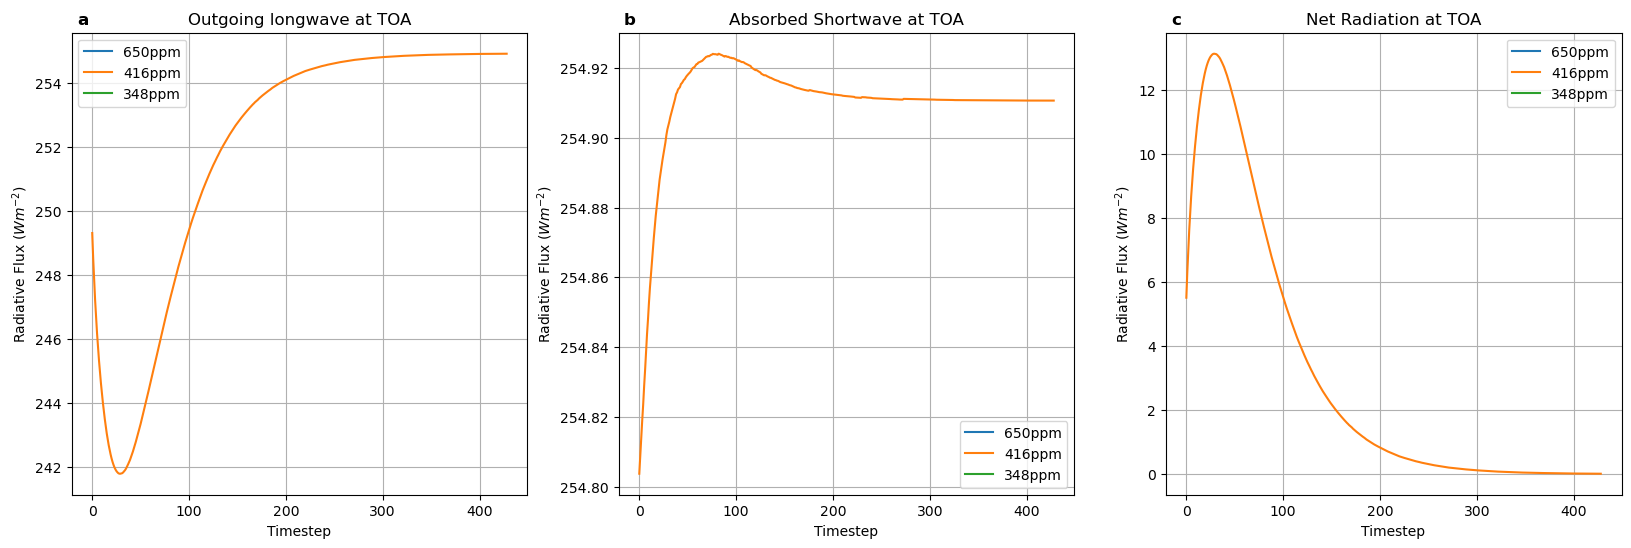

In [51]:
fig = plt.figure(figsize=(20,6))
ax1 = plt.subplot2grid((1,3), (0,0))
ax2 = plt.subplot2grid((1,3), (0,1))
ax3 = plt.subplot2grid((1,3), (0,2))
#plt.setp([ax1,ax2], xlim=(75,275), ylim=(0,1000))

ax1.plot(np.arange(len(olr_650)),olr_650,label='650ppm')
ax1.plot(np.arange(len(olr_416)),olr_416,label='416ppm')
ax1.plot(np.arange(len(olr_348)),olr_348,label='348ppm')
ax1.set_ylabel('Radiative Flux ($Wm^{-2}$)')
ax1.set_xlabel('Timestep')
ax1.set_title('Outgoing longwave at TOA')
ax1.legend()
ax1.grid()

ax2.plot(np.arange(len(asr_650)),asr_650,label='650ppm')
ax2.plot(np.arange(len(asr_416)),asr_416,label='416ppm')
ax2.plot(np.arange(len(asr_348)),asr_348,label='348ppm')
ax2.set_ylabel('Radiative Flux ($Wm^{-2}$)')
ax2.set_xlabel('Timestep')
ax2.set_title('Absorbed Shortwave at TOA')
ax2.legend()
ax2.grid()

ax3.plot(np.arange(len(net_650)),net_650,label='650ppm')
ax3.plot(np.arange(len(net_416)),net_416,label='416ppm')
ax3.plot(np.arange(len(net_348)),net_348,label='348ppm')
ax3.set_ylabel('Radiative Flux ($Wm^{-2}$)')
ax3.set_xlabel('Timestep')
ax3.set_title('Net Radiation at TOA')
ax3.legend()
ax3.grid()

make_textbox(ax1,'a')
make_textbox(ax2,'b')
make_textbox(ax3,'c')

notes to self:
might show temperatures + heating rates as well? 
show absorbtivity of atms as well? 

## B. All-sky conditions 
Now let's add some cloud to the model. 

Reference: cloud profile like https://github.com/climlab/climlab/blob/9584063ae4dca19f8fb3ffdb5aa399eaff18fdba/climlab/tests/test_rrtm.py#L65


In [52]:
mystate
lev = Qglobal.lev
cldfrac = 0.5 # layer cloud fraction
r_liq = 19.  # Cloud water drop effective radius (microns)
clwp = 20  # in-cloud liquid water path (g/m2)
#  The cloud fraction is a Gaussian bump centered at level i
i = 22
cldfrac = np.array(cldfrac*(np.exp(-(lev-lev[i])**2/(2*i)**2))**0.1)
mycloud = {'cldfrac': np.zeros_like(mystate.Tatm) + cldfrac,
            'clwp': np.zeros_like(mystate.Tatm) + clwp,
            'r_liq': np.zeros_like(mystate.Tatm) + r_liq,
            }

mycloud

{'cldfrac': Field([9.29022421e-18, 1.30810343e-17, 2.34112766e-17, 5.61194881e-17,
        1.76914811e-16, 6.81641028e-16, 2.79234130e-15, 9.78772143e-15,
        3.26824573e-14, 1.31004985e-13, 6.43557095e-13, 3.95238765e-12,
        3.08753380e-11, 3.10448461e-10, 4.02662760e-09, 6.64534082e-08,
        1.34258732e-06, 3.07574674e-05, 6.99321387e-04, 1.27094124e-02,
        1.11657017e-01, 3.60859254e-01, 5.00000000e-01, 4.08673160e-01,
        2.87844798e-01, 2.21942528e-01]),
 'clwp': Field([20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
        20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.]),
 'r_liq': Field([19., 19., 19., 19., 19., 19., 19., 19., 19., 19., 19., 19., 19.,
        19., 19., 19., 19., 19., 19., 19., 19., 19., 19., 19., 19., 19.])}

### Check out vertical profile of clouds

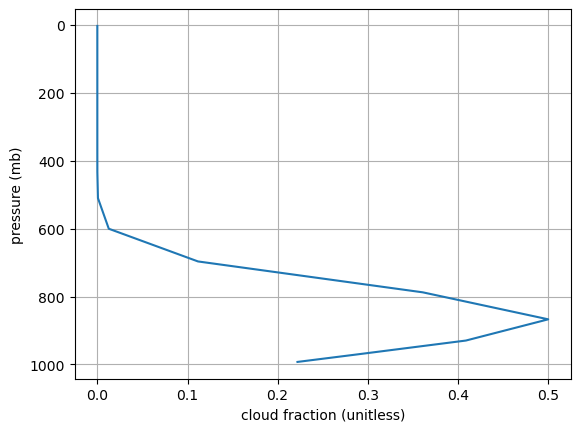

In [53]:
plt.plot(cldfrac,lev)
plt.gca().invert_yaxis()
plt.ylabel('pressure (mb)'), plt.xlabel('cloud fraction (unitless)'),plt.grid();

### Check out fluxes at TOA with changing CO2

In [54]:
olr_348_cld = [] #TOA outgoing longwave radiation in W/m2 (+ve up)
asr_348_cld = [] #TOA absorbed shortwave radiation at TOA in W/m2 (+ve down)
net_348_cld = [] #net TOA radiation 
olr_416_cld = [] #TOA outgoing longwave radiation in W/m2 (+ve up)
asr_416_cld = [] #TOA absorbed shortwave radiation at TOA in W/m2 (+ve down)
net_416_cld = [] #net TOA radiation 
olr_650_cld = [] #TOA outgoing longwave radiation in W/m2 (+ve up)
asr_650_cld = [] #TOA absorbed shortwave radiation at TOA in W/m2 (+ve down)
net_650_cld = [] #net TOA radiation 

In [55]:
# Plot net TOA fluxes under different concentrations of CO2 

co2_lv = [348,416.55,650] #in ppm

#radmodel.absorber_vmr['CO2'] = 416.55 / 1E6 #edit here 

count = 0 

mystate = climlab.column_state(lev=Qglobal.lev, water_depth=2.5)
radmodel = climlab.radiation.RRTMG(name='Radiation (all gases)',  # give our model a name!
                                state=mystate,   # give our model an initial condition!
                                  specific_humidity=Qglobal.values,  # tell the model how much water vapor there is
                                  albedo = 0.25,  # this the SURFACE shortwave albedo
                                  timestep = climlab.constants.seconds_per_day,  # set the timestep to one day (measured in seconds)
                                  **mycloud
                                 )
radmodel.step_forward()
radmodel.absorber_vmr['CO2'] = 348 / 1E6 #Edit here 
while np.abs(radmodel.ASR - radmodel.OLR) > 0.01:
    # Take one step forward in time 
    radmodel.step_forward()
    olr_348_cld.append(radmodel.OLR[0]) #change var names 
    asr_348_cld.append(radmodel.ASR[0])
    net_348_cld.append(radmodel.ASR[0] - radmodel.OLR[0])
    count+=1 

count

676

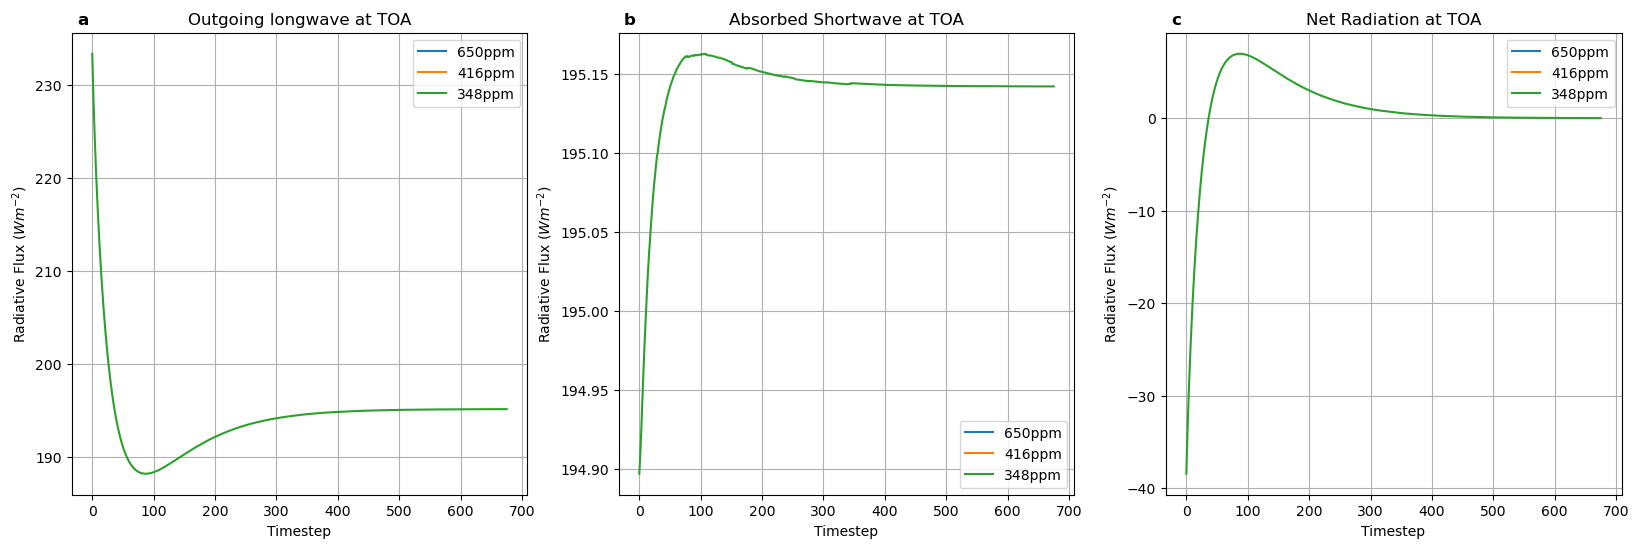

In [56]:
fig = plt.figure(figsize=(20,6))
ax1 = plt.subplot2grid((1,3), (0,0))
ax2 = plt.subplot2grid((1,3), (0,1))
ax3 = plt.subplot2grid((1,3), (0,2))
#plt.setp([ax1,ax2], xlim=(75,275), ylim=(0,1000))

ax1.plot(np.arange(len(olr_650_cld)),olr_650_cld,label='650ppm')
ax1.plot(np.arange(len(olr_416_cld)),olr_416_cld,label='416ppm')
ax1.plot(np.arange(len(olr_348_cld)),olr_348_cld,label='348ppm')
ax1.set_ylabel('Radiative Flux ($Wm^{-2}$)')
ax1.set_xlabel('Timestep')
ax1.set_title('Outgoing longwave at TOA')
ax1.legend()
ax1.grid()

ax2.plot(np.arange(len(asr_650_cld)),asr_650_cld,label='650ppm')
ax2.plot(np.arange(len(asr_416_cld)),asr_416_cld,label='416ppm')
ax2.plot(np.arange(len(asr_348_cld)),asr_348_cld,label='348ppm')
ax2.set_ylabel('Radiative Flux ($Wm^{-2}$)')
ax2.set_xlabel('Timestep')
ax2.set_title('Absorbed Shortwave at TOA')
ax2.legend()
ax2.grid()

ax3.plot(np.arange(len(net_650_cld)),net_650_cld,label='650ppm')
ax3.plot(np.arange(len(net_416_cld)),net_416_cld,label='416ppm')
ax3.plot(np.arange(len(net_348_cld)),net_348_cld,label='348ppm')
ax3.set_ylabel('Radiative Flux ($Wm^{-2}$)')
ax3.set_xlabel('Timestep')
ax3.set_title('Net Radiation at TOA')
ax3.legend()
ax3.grid()

make_textbox(ax1,'a')
make_textbox(ax2,'b')
make_textbox(ax3,'c')

#### Q: Why high CO2 (RCP4.5 case) reaches balance so early??? (I don't know - please check)

# 2. How are clouds represented in RRTMG? 

## A. Model Schemes on Cloud Representation: Cloud Overlap

Remember the infinite combination of how cloud can be organized within a grid cell? McICA comes into play! 

**elaborate the main types of cloud organization methods like random, maximum and random maximum. make note of the latest updates and field focus on exponential - but it is not available in climlab :(** 

**insert graph with the 3 methods from Zhang and Jing 2016 - downloaded** 

In [59]:
# define Cloud overlap method, 0: Clear only, 1: Random, 2,  Maximum/random 3: Maximum
ICLD = 1
# 3 models, one SW and one LW to do manual McICA, one combined model to compare with.
mystate = climlab.column_state(lev=Qglobal.lev, water_depth=2.5)

radmodel_sw = climlab.radiation.RRTMG_SW(name='Radiation (all gases)',  # give our model a name!
                              state=mystate,   # give our model an initial condition!
                              specific_humidity=Qglobal.values,  # tell the model how much water vapor there is
                              albedo = 0.25,  # this the SURFACE shortwave albedo
                              timestep = climlab.constants.seconds_per_day,  # set the timestep to one day (measured in seconds)
                              icld = ICLD,
                              **mycloud
                             )

radmodel_lw = climlab.radiation.RRTMG_LW(name='Radiation (all gases)',  # give our model a name!
                              state=mystate,   # give our model an initial condition!
                              specific_humidity=Qglobal.values,  # tell the model how much water vapor there is
                              albedo = 0.25,  # this the SURFACE shortwave albedo
                              timestep = climlab.constants.seconds_per_day,  # set the timestep to one day (measured in seconds)
                              icld = ICLD,
                              **mycloud
                             )

radmodel_comb = climlab.radiation.RRTMG(name='Radiation (all gases)',  # give our model a name!
                              state=mystate,   # give our model an initial condition!
                              specific_humidity=Qglobal.values,  # tell the model how much water vapor there is
                              albedo = 0.25,  # this the SURFACE shortwave albedo
                              timestep = climlab.constants.seconds_per_day,  # set the timestep to one day (measured in seconds)
                              icld = ICLD,
                              **mycloud
                             )
                             
p_lev = radmodel_comb.lev_bounds

In [60]:
count = 0
nmcica = 1 # ****** check => number of samples to be initialized in mcica 
while True:
    step_model(radmodel_sw,radmodel_lw,nmcica)
    asr = radmodel_sw.diagnostics['ASR']
    olr = radmodel_lw.diagnostics['OLR']
    count += 1
    if count > 1000 or np.abs(asr-olr)<0.01:
        break
count

687

In [61]:
radmodel_comb.integrate_converge(1e-2)

Total elapsed time is 3.997347513512951 years.


In [62]:
# define Cloud overlap method, 0: Clear only, 1: Random, 2,  Maximum/random 3: Maximum
ICLD = 1
# The same model initialized as above
mystate = climlab.column_state(lev=Qglobal.lev, water_depth=2.5)
radmodel_sw = climlab.radiation.RRTMG_SW(name='Radiation (all gases)',  # give our model a name!
                              state=mystate,   # give our model an initial condition!
                              specific_humidity=Qglobal.values,  # tell the model how much water vapor there is
                              albedo = 0.25,  # this the SURFACE shortwave albedo
                              timestep = climlab.constants.seconds_per_day,  # set the timestep to one day (measured in seconds)
                              icld = ICLD,
                              **mycloud
                             )
radmodel_lw = climlab.radiation.RRTMG_LW(name='Radiation (all gases)',  # give our model a name!
                              state=mystate,   # give our model an initial condition!
                              specific_humidity=Qglobal.values,  # tell the model how much water vapor there is
                              albedo = 0.25,  # this the SURFACE shortwave albedo
                              timestep = climlab.constants.seconds_per_day,  # set the timestep to one day (measured in seconds)
                              icld = ICLD,
                              **mycloud
                             )

In [63]:
# Use 20 mcica samples per iteration for manual iteration and compare with one sample default model again.
count = 0
nmcica = 200
while True:
    step_model(radmodel_sw,radmodel_lw,nmcica)
    asr = radmodel_sw.diagnostics['ASR']
    olr = radmodel_lw.diagnostics['OLR']
    count += 1
    if count > 1000 or np.abs(asr-olr)<0.01:
        break
count

694

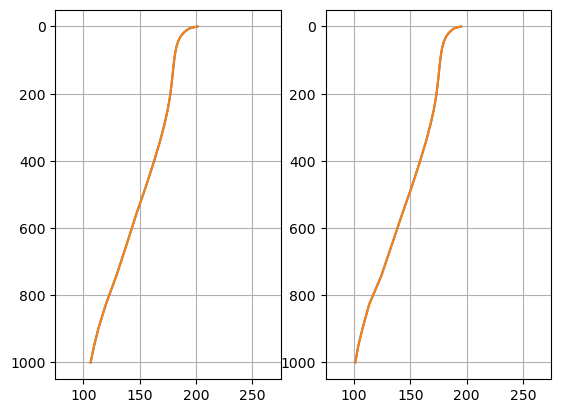

In [64]:
fig,axes = plt.subplots(1,2)

axes[0].plot(climlab.to_xarray(radmodel_sw.SW_flux_net),p_lev)
axes[0].plot(climlab.to_xarray(radmodel_lw.LW_flux_net),p_lev)
axes[0].set_xlim(75,275)
axes[0].invert_yaxis()
axes[0].grid()

axes[1].plot(climlab.to_xarray(radmodel_comb.SW_flux_net),p_lev)
axes[1].plot(climlab.to_xarray(radmodel_comb.LW_flux_net),p_lev)
axes[1].set_xlim(75,275)
axes[1].invert_yaxis()
axes[1].grid()


## B. Physical Cloud Representation and Interpretations

In [65]:
mystate
lev = Qglobal.lev
cldfrac = 0.5 # layer cloud fraction
r_liq = 19.  # Cloud water drop effective radius (microns)
clwp = 20  # in-cloud liquid water path (g/m2)
#  The cloud fraction is a Gaussian bump centered at level i
i = 22
cldfrac = np.array(cldfrac*(np.exp(-(lev-lev[i])**2/(2*i)**2))**0.1)
mycloud = {'cldfrac': np.zeros_like(mystate.Tatm) + cldfrac,
            'clwp': np.zeros_like(mystate.Tatm) + clwp,
            'r_liq': np.zeros_like(mystate.Tatm) + r_liq,
            }
mycloud

{'cldfrac': Field([9.29022421e-18, 1.30810343e-17, 2.34112766e-17, 5.61194881e-17,
        1.76914811e-16, 6.81641028e-16, 2.79234130e-15, 9.78772143e-15,
        3.26824573e-14, 1.31004985e-13, 6.43557095e-13, 3.95238765e-12,
        3.08753380e-11, 3.10448461e-10, 4.02662760e-09, 6.64534082e-08,
        1.34258732e-06, 3.07574674e-05, 6.99321387e-04, 1.27094124e-02,
        1.11657017e-01, 3.60859254e-01, 5.00000000e-01, 4.08673160e-01,
        2.87844798e-01, 2.21942528e-01]),
 'clwp': Field([20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
        20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.]),
 'r_liq': Field([19., 19., 19., 19., 19., 19., 19., 19., 19., 19., 19., 19., 19.,
        19., 19., 19., 19., 19., 19., 19., 19., 19., 19., 19., 19., 19.])}

In [66]:
# Plot net TOA fluxes under different concentrations of CO2 

co2_lv = [348,416.55,650] #in ppm

#radmodel.absorber_vmr['CO2'] = 416.55 / 1E6 #edit here 

count = 0 

mystate = climlab.column_state(lev=Qglobal.lev, water_depth=2.5)
radmodel = climlab.radiation.RRTMG(name='Radiation (all gases)',  # give our model a name!
                                state=mystate,   # give our model an initial condition!
                                  specific_humidity=Qglobal.values,  # tell the model how much water vapor there is
                                  albedo = 0.25,  # this the SURFACE shortwave albedo
                                  timestep = climlab.constants.seconds_per_day,  # set the timestep to one day (measured in seconds)
                                  **mycloud
                                 )
radmodel.step_forward()
radmodel.absorber_vmr['CO2'] = 348 / 1E6 #Edit here 
while np.abs(radmodel.ASR - radmodel.OLR) > 0.01:
    # Take one step forward in time 
    radmodel.step_forward()
    olr_348_cld.append(radmodel.OLR[0]) #change var names 
    asr_348_cld.append(radmodel.ASR[0])
    net_348_cld.append(radmodel.ASR[0] - radmodel.OLR[0])
    count+=1 

count

676